<h1 align="center">
        <picture>
         <source media="(prefers-color-scheme: dark)" srcset="https://user-images.githubusercontent.com/16140783/218357099-29d4848f-89ee-463e-9ead-40f27c976f61.png">
         <img width="300" src="https://user-images.githubusercontent.com/16140783/218437368-1aa8506c-1ed8-460a-99de-d2c081557170.png" align="center"></img>
    </picture><br/><br/>Subvocalization EMG - PoC<sub><sup><br/>(Subvocalization)</sup></sub>
</h1>

Project for recording and training subvocalization **EMG** data with the Cyton Board. This is the final PoC of the project containing the steps of processing and training with real subvocalization data. Developed by **Mateus de Aquino Batista** for the Bachelor's Degree Final Project.


### Packages

First, after recording the raw data with Brainflow, we can start processing the data, so let's start installing the required packages for reading the saves, preprocessing, plotting and training a new model.

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
gpu_devices = tf.config.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
    
from brainflow.data_filter import DataFilter, FilterTypes, DetrendOperations, NoiseTypes, AggOperations
from brainflow.board_shim import BoardShim, BoardIds
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import np_utils
import os

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Built with CUDA: ", tf.test.is_built_with_cuda())

os.chdir('../')

2023-12-02 08:22:17.376470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 08:22:17.376627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 08:22:17.660812: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 08:22:18.525021: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-02 08:23:12.753964: W tensorflow/compiler/tf2

Num GPUs Available:  1
Built with CUDA:  True


### Reading raw EMG data

The sEMG data will be read from the Cyton Dongle through [BrainFlow](https://brainflow.readthedocs.io/en/stable/SupportedBoards.html#cyton), you can also check the [Code Samples](https://brainflow.readthedocs.io/en/stable/Examples.html) section to know how to get the data from the board and read/write it to a csv file.

In [99]:
csv = pd.read_csv("dist/saves/FMatYN5C.csv")

csv

,WORD,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8
0,sim,16321.914354,-18809.976436,14205.405319,-7663.653214,4219.584670,-187500.022352,-187500.022352,-187500.022352
1,sim,16192.520105,-18844.509881,14203.438366,-7631.466702,4185.788832,-187500.022352,-187500.022352,-187500.022352
2,sim,16245.605498,-18831.702332,14189.624988,-7662.535627,4176.892838,-187500.022352,-187500.022352,-187500.022352
3,sim,16372.608110,-18795.447802,14193.000101,-7693.559848,4213.013257,-187500.022352,-187500.022352,-187500.022352
4,sim,16342.321496,-18804.276741,14202.901924,-7670.962235,4222.021010,-187500.022352,-187500.022352,-187500.022352
...,...,...,...,...,...,...,...,...,...
75189,sim,14854.254109,-26906.381775,13427.989295,-8364.045127,4101.656866,-187500.022352,-187500.022352,-187500.022352
75190,sim,14843.972307,-26914.651920,13424.345961,-8372.762307,4090.391587,-187500.022352,-187500.022352,-187500.022352
75191,sim,14898.778784,-26863.354667,13431.185595,-8396.656322,4124.388590,-187500.022352,-187500.022352,-187500.022352
75192,sim,14902.913857,-26867.132111,13417.506327,-8398.913848,4130.915300,-187500.022352,-187500.022352,-187500.022352


We can plot the data for each channel directly to [Matplotlib](https://matplotlib.org/). As you could tell, these graphing tools have a way higher resolution than the one used in the frontend for debugging ([Chart.js](https://www.chartjs.org/)).

In [100]:
restored_data = csv.copy()
board_id = BoardIds.CYTON_BOARD.value

# f, axarr = plt.subplots(6, 2, figsize=(14,5))

# axs = restored_data[df_channels][:12000].plot(subplots=True, ax=axarr[:,0])
# for i,ax in enumerate(axs):
    # axs[i].legend(loc="upper right")
    # axs[i].axvspan(5900, 6100, alpha=0.5, ec='red', fill=False)

# axs = restored_data[df_channels][5900:6100].plot(subplots=True, ax=axarr[:,1])
# for i,ax in enumerate(axs):
    # axs[i].legend(loc="upper right")
    # axs[i].axvspan(5900, 6100, alpha=1, ec='red', fill=False)

# plt.show()

BoardShim.get_ecg_channels(board_id)

[1, 2, 3, 4, 5, 6, 7, 8]

### Preprocessing

With our 6 channels data in hand, we can perform a Butterworth filter to select the frequency range we want to keep, here we want a lowcut of 3.0 and a highcut of 45.0:

In [103]:
eeg_channels = [1, 2, 3, 4, 5]
df_channels = list(map(lambda x: "Channel_%s" % (x), eeg_channels))
sampling_rate = BoardShim.get_sampling_rate(board_id)
exg_channels = BoardShim.get_exg_channels(board_id)

def plot(restored_data, plots=6):
    window = 1300
    offset = 10300
    start = offset-int(window/2)
    end = offset+int(window/2)

    if plots%2==0:
      f, axarr = plt.subplots(len(eeg_channels), 2, figsize=(14,5))
      axs = restored_data[df_channels].plot(subplots=True, ax=axarr[:,0])
      for i,ax in enumerate(axs):
          axs[i].legend(loc="upper right")
          axs[i].axvspan(start, end, alpha=0.5, ec='red', fill=False)
    
      axs = restored_data[df_channels][start:end].plot(subplots=True, ax=axarr[:,1])
      for i,ax in enumerate(axs):
          axs[i].legend(loc="upper right")
          axs[i].axvspan(start, end, alpha=1, ec='red', fill=False)
    
      plt.show()
    
    emg_words = []
    emg_data = []
    
    total_samples = len(restored_data['Channel_1'])
    samples = 220
    words_to_visualize = 10
    words_offset = 180
    
    words_end = words_offset + words_to_visualize
    
    x = restored_data.drop(restored_data.columns[0],axis=1).to_numpy()
    preprocessed_data = x[:, :len(eeg_channels)]
    
    word = None
    data = None
    for i in range(len(preprocessed_data)):
      if len(emg_words) == words_end: break
      if i == 0:
        word = csv.iloc[0, 0]
        data = preprocessed_data[0, :]
      elif csv.iloc[i, 0] == word:
        data = np.vstack((data, preprocessed_data[i, :]))
      else:
        emg_words.append(word)
        emg_data.append(data)
        word = csv.iloc[i, 0]
        data = preprocessed_data[i, :]
    
    emg_words.append(word)
    emg_data.append(data)

    if plots%3==0:
      plt.figure()
      _f, axarr = plt.subplots(len(emg_words[words_offset:words_end]), 1, constrained_layout=True, figsize=(10, words_to_visualize*2/3))
      for i, word in enumerate(emg_words[words_offset:words_end]):
          axarr[i].imshow(np.transpose(emg_data[words_offset+i]), cmap='hot', interpolation='none', aspect=2)
          axarr[i].set_ylabel(word, fontsize=12, y=.20, ha='right', rotation='horizontal', labelpad=10) 
      plt.show()

<Figure size 640x480 with 0 Axes>

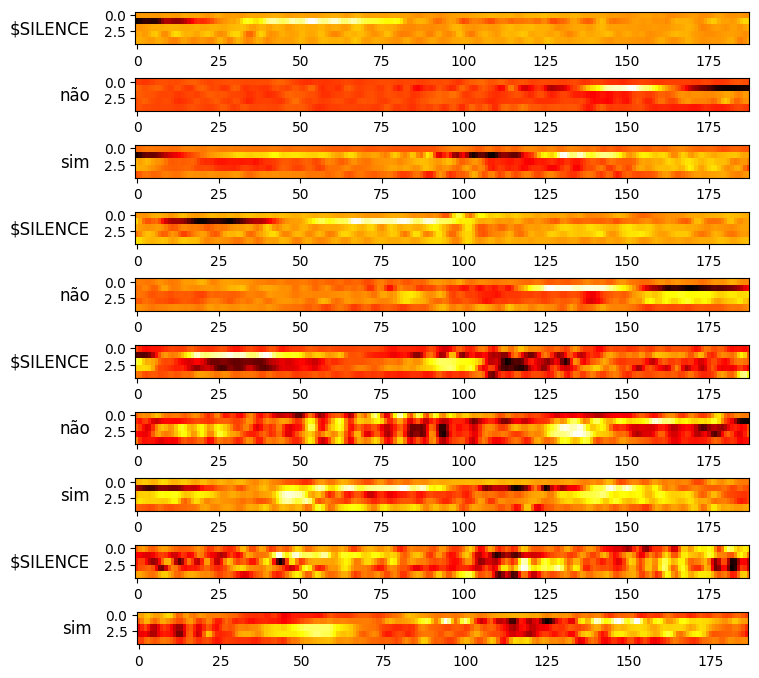

In [104]:
from brainflow.data_filter import DataFilter, AggOperations, WaveletTypes, NoiseEstimationLevelTypes, \
    WaveletExtensionTypes, ThresholdTypes, WaveletDenoisingTypes

restored_data = csv.copy()
for count, channel in enumerate(df_channels):
    if count >= 8:
        continue
    channel_data = restored_data[channel].to_numpy()
    DataFilter.detrend(channel_data, DetrendOperations.CONSTANT.value)
    DataFilter.remove_environmental_noise(channel_data, sampling_rate, NoiseTypes.SIXTY.value);
    DataFilter.perform_bandpass(channel_data, sampling_rate, 2, 57, 4, FilterTypes.BUTTERWORTH.value, 1.0)
    DataFilter.perform_rolling_filter(channel_data, 3, AggOperations.MEAN.value)
    DataFilter.perform_wavelet_denoising(channel_data, WaveletTypes.BIOR3_9, 3, WaveletDenoisingTypes.SURESHRINK, ThresholdTypes.HARD, WaveletExtensionTypes.SYMMETRIC, NoiseEstimationLevelTypes.FIRST_LEVEL)

plot(restored_data, 3)

### Words visualization

In this session we recorded two words "Yes" and "No" plus "Silence" with the Cyton board.
Now that we have all the session preprocessed, we need to split it in 200 samples per word, once these words are a 2d array (sample x channel) inside a list of words, all the words could be individually seen as a 2-dimensional image heatmap, knowing the columns represents each channel, and the rows are the data recorded over time:

<Figure size 640x480 with 0 Axes>

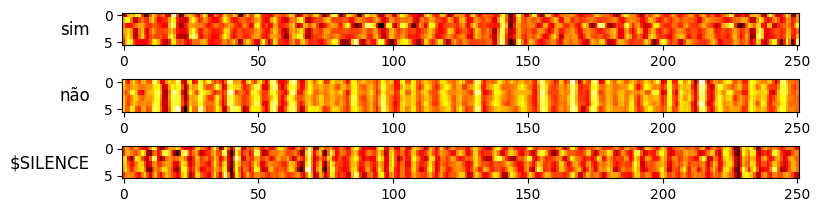

In [260]:
emg_words = []
emg_data = []

total_samples = len(restored_data['Channel_1'])
offset = 1200
samples = 251
words_to_visualize = 3

for i in range(words_to_visualize):
    sample_offset = offset + int(total_samples * (i/(words_to_visualize)))
    word = restored_data['WORD'][sample_offset]
    emg_words.append(word)
    data = restored_data[df_channels][sample_offset:(sample_offset+samples)]
    emg_data.append(data)

plt.figure()
_f, axarr = plt.subplots(len(emg_words), 1, constrained_layout=True, figsize=(10, words_to_visualize*2/3))
for i, word in enumerate(emg_words):
    axarr[i].imshow(np.transpose(emg_data[i]), cmap='hot', interpolation='none', aspect=2)
    axarr[i].set_ylabel(word, fontsize=12, y=.20, ha='right', rotation='horizontal', labelpad=10) 
plt.show()

### Training the Neural Network

We need to factorize the words array so we can get an unique list of the words used, and also retreive a list the model can read as an expected output:

In [3]:
from backend.training import train_network

Original words count: 400
Original Avg Samples (per word): 187
New words count: 400 (removed 0 words)
New Avg Samples (per word): 187
New Samples: 184 (removed 3 samples from average)


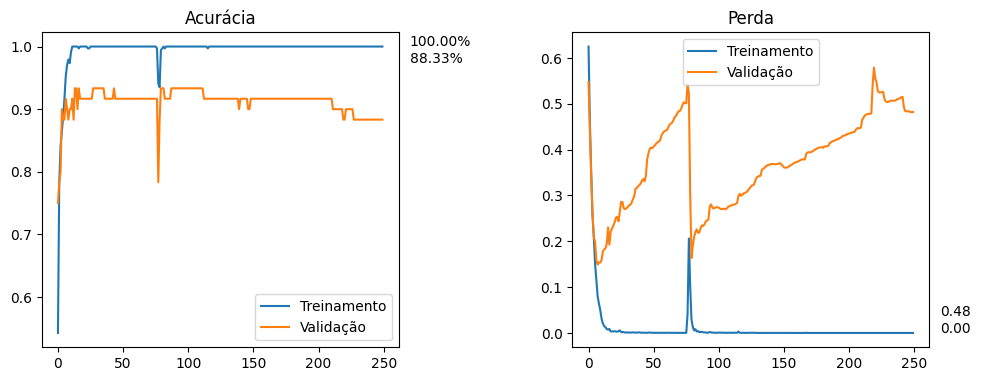

In [107]:
words_map, samples, model, history = train_network(85, ["FMatYN5C"], 20, 250, 5, 120)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

ax1.set_title("Acurácia")
ax1.plot(accuracy, label="Treinamento")
ax1.plot(val_accuracy, label="Validação")
ax1.legend(fontsize="10")

ax2.set_title("Perda")
ax2.plot(loss, label="Treinamento")
ax2.plot(val_loss, label="Validação")
ax2.legend(fontsize="10")

i = 0

for var in (val_accuracy, accuracy):
    i+=1
    ax1.annotate('%2.2f%%' % (var[-1]*100), xy=(1, 0.85), xytext=(8, i*12), 
                 xycoords=('axes fraction', 'axes fraction'), textcoords='offset points')

for var in (loss, val_loss):
    i-=1
    ax2.annotate('%0.2f' % var[-1], xy=(1, 0.1), xytext=(8, -i*12), 
                 xycoords=('axes fraction', 'axes fraction'), textcoords='offset points')


fig.tight_layout(pad=5.0)
plt.show()